In [2]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import trustworthiness
import Template
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

Template = Template.Template()

# import the data from all sheets of the Excel file

df0 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=0)
df1 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=1)
df2 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=2)
df3 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=3)


df0_NotFEH0 = df0[df0['Tratamiento'] != 'Fus_EH']

df_NotFEH0 = pd.concat([df0_NotFEH0, df1, df2, df3], ignore_index=True)


## Clasification of Healthy plants vs Unhealthy plants

#### Data processing for classification

In [8]:
# Make a new column 'Health_Status' based on 'Tratamiento'

df_NotFEH0['Health_Status'] = df_NotFEH0['Tratamiento'].apply(lambda x: 'Healthy' if x == 'Control' else 'Unhealthy')

df_NotFEH0.head()



,Tratamiento,Planta,350,351,352,353,354,355,356,357,...,2492,2493,2494,2495,2496,2497,2498,2499,2500,Health_Status
0,Control,1,0.061030,0.060394,0.053344,0.054736,0.057163,0.055928,0.049880,0.043096,...,0.044834,0.044802,0.044657,0.044370,0.044198,0.044046,0.043928,0.043878,0.043752,Healthy
1,Control,2,0.060823,0.060909,0.056016,0.056755,0.057975,0.056499,0.051715,0.047413,...,0.037458,0.037266,0.037120,0.036929,0.036832,0.036861,0.036779,0.036661,0.036570,Healthy
2,Control,3,0.059742,0.060113,0.057320,0.059280,0.059741,0.057078,0.053557,0.049205,...,0.036049,0.035732,0.035558,0.035431,0.035338,0.035368,0.035286,0.035157,0.035058,Healthy
3,Control,4,0.048861,0.047099,0.044486,0.049340,0.052701,0.050598,0.044007,0.038449,...,0.033762,0.033693,0.033536,0.033412,0.033204,0.032831,0.032637,0.032501,0.032376,Healthy
4,Control,5,0.063155,0.060788,0.057388,0.058424,0.060128,0.059009,0.053017,0.048921,...,0.033729,0.033675,0.033571,0.033515,0.033441,0.033317,0.033257,0.033285,0.033205,Healthy


In [9]:
# data treatment

# Data preparation for model production
df_X = df_NotFEH0.drop(columns=['Health_Status'])

X = df_X.iloc[:, 3:].values  

y = df_NotFEH0['Health_Status'].values  

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

## Logistic Regression 

In [18]:
# Lets start with a simple Logistic Regression model and pca

pca = PCA(n_components=40) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print('PCA explained variance ratio:', pca.explained_variance_ratio_.sum())

log_reg = LogisticRegression(penalty='l2', dual=False, C=1.0, solver='lbfgs', max_iter=3000)
log_reg.fit(X_train_pca, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_pca)
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)

PCA explained variance ratio: 0.9999808882419305
Accuracy: 0.8817204301075269
Classification Report:
               precision    recall  f1-score   support

     Healthy       1.00      0.08      0.15        12
   Unhealthy       0.88      1.00      0.94        81

    accuracy                           0.88        93
   macro avg       0.94      0.54      0.55        93
weighted avg       0.90      0.88      0.84        93



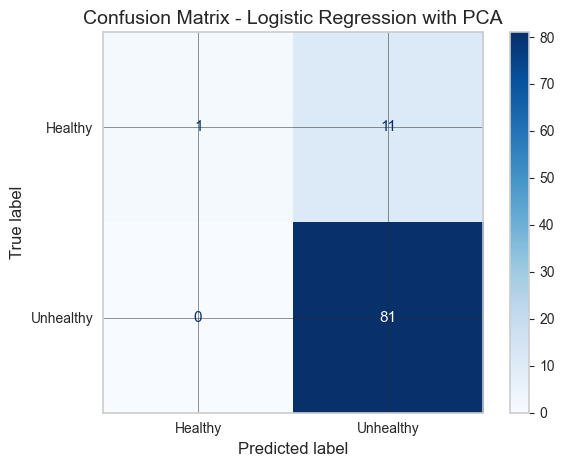

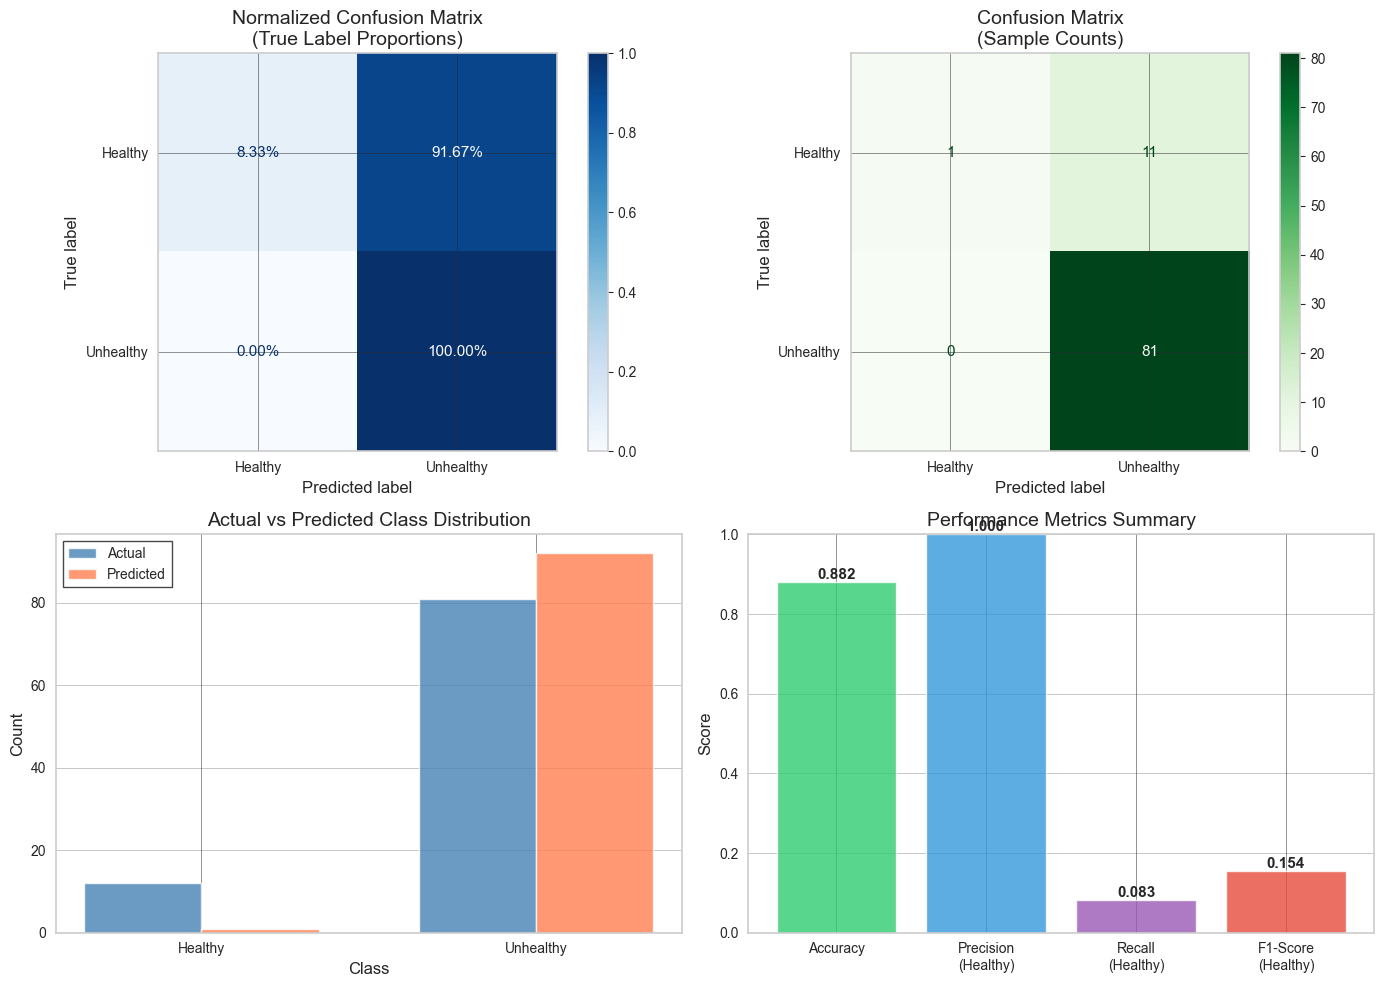

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Display the confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression with PCA')
plt.tight_layout()
plt.show()

# Create a comprehensive visualization of results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix (normalized)
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=log_reg.classes_)
disp_norm.plot(ax=axes[0, 0], cmap='Blues', values_format='.2%')
axes[0, 0].set_title('Normalized Confusion Matrix\n(True Label Proportions)')

# 2. Confusion Matrix (counts)
disp.plot(ax=axes[0, 1], cmap='Greens')
axes[0, 1].set_title('Confusion Matrix\n(Sample Counts)')

# 3. Class distribution comparison
class_labels = ['Healthy', 'Unhealthy']
y_test_counts = pd.Series(y_test).value_counts()
y_pred_counts = pd.Series(y_pred).value_counts()

x = np.arange(len(class_labels))
width = 0.35

axes[1, 0].bar(x - width/2, [y_test_counts.get(label, 0) for label in class_labels], 
               width, label='Actual', alpha=0.8, color='steelblue')
axes[1, 0].bar(x + width/2, [y_pred_counts.get(label, 0) for label in class_labels], 
               width, label='Predicted', alpha=0.8, color='coral')
axes[1, 0].set_xlabel('Class')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Actual vs Predicted Class Distribution')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(class_labels)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Performance metrics summary

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision\n(Healthy)': precision_score(y_test, y_pred, pos_label='Healthy'),
    'Recall\n(Healthy)': recall_score(y_test, y_pred, pos_label='Healthy'),
    'F1-Score\n(Healthy)': f1_score(y_test, y_pred, pos_label='Healthy')
}

bars = axes[1, 1].bar(metrics.keys(), metrics.values(), color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'], alpha=0.8)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Performance Metrics Summary')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



In [16]:
# Define a more comprehensive parameter grid for hyperparameter tuning
param_grid = [
    # L1 regularization options
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['l1'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga'],
        'model__class_weight': [None, 'balanced']
    },
    # L2 regularization options
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['l2'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga', 'lbfgs'],
        'model__class_weight': [None, 'balanced']
    },
    # Elasticnet option (saga only)
    {
        'PCA__n_components': [5, 10, 15, 20, 30],
        'model__penalty': ['elasticnet'],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['saga'],
        'model__l1_ratio': [0.2, 0.5, 0.8],
        'model__class_weight': [None, 'balanced']
    }
]

# Create a pipeline
pipeline = Pipeline([
    ('PCA', PCA()),
    ('model', LogisticRegression(max_iter=1000))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)


KeyboardInterrupt: 

## SVM

In [ ]:
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 30, 40],
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'svm__degree': [2, 3, 4],
    'svm__class_weight': ['balanced', None]
}

pipeline = Pipeline([    
    ('pca', PCA()),                   
    ('svm', SVC())  
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='balanced_accuracy')

grid_search.fit(X_train, y_train)

print(f"Best cross-validation score (Accuracy): {grid_search.best_score_:.4f}")
print("Best parameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"\nAccuracy on the test set: {accuracy:.4f}")

y_pred = best_model.predict(X_test)